In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
data = pd.read_csv("7.csv")

In [4]:
data["col0_encoded"] = data.iloc[:, 0].astype("category").cat.codes + 1

In [5]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

train_data, temp_data = train_test_split(data, test_size=0.4, stratify=data.iloc[:, -1], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data.iloc[:, -1], random_state=42)

In [6]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

In [7]:
# Define features (last 3 columns excluding the target)
X_train = train_data.iloc[:, -4:-1]
X_val = val_data.iloc[:, -4:-1]
X_test = test_data.iloc[:, -4:-1]

# Define target (last column)
y_train = train_data.iloc[:, -1]
y_val = val_data.iloc[:, -1]
y_test = test_data.iloc[:, -1]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np 

# 🚀 Standardize the Data
scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_val_scaled = torch.tensor(scaler.transform(X_val), dtype=torch.float32)

# 🎯 Convert Labels (Zero-indexed)
y_train_tensor = torch.tensor(y_train.values - 1, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values - 1, dtype=torch.long)

# 📦 Create DataLoader
train_dataset = TensorDataset(X_train_scaled, y_train_tensor)
val_dataset = TensorDataset(X_val_scaled, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 🧠 **Neural Network Model**
class FishClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_classes=9):
        super(FishClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc4 = nn.Linear(hidden_size // 2, num_classes)
        self.dropout = nn.Dropout(p=0.4)  

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 🎯 Initialize Model
input_dim = X_train.shape[1]
model = FishClassifier(input_size=input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)  
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

# 🚀 Training Loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    scheduler.step()

    # 🎯 Validation Accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {acc:.4f}")

# 💾 Save Model
torch.save(model.state_dict(), "fish_classifier.pth")


Epoch [1/200], Validation Accuracy: 0.8983
Epoch [2/200], Validation Accuracy: 0.8897
Epoch [3/200], Validation Accuracy: 0.9044
Epoch [4/200], Validation Accuracy: 0.9191
Epoch [5/200], Validation Accuracy: 0.9142
Epoch [6/200], Validation Accuracy: 0.9179
Epoch [7/200], Validation Accuracy: 0.9007
Epoch [8/200], Validation Accuracy: 0.9179
Epoch [9/200], Validation Accuracy: 0.9069
Epoch [10/200], Validation Accuracy: 0.9020
Epoch [11/200], Validation Accuracy: 0.9032
Epoch [12/200], Validation Accuracy: 0.9032
Epoch [13/200], Validation Accuracy: 0.9081
Epoch [14/200], Validation Accuracy: 0.9154
Epoch [15/200], Validation Accuracy: 0.9154
Epoch [16/200], Validation Accuracy: 0.8799
Epoch [17/200], Validation Accuracy: 0.8762
Epoch [18/200], Validation Accuracy: 0.9056
Epoch [19/200], Validation Accuracy: 0.9093
Epoch [20/200], Validation Accuracy: 0.9130
Epoch [21/200], Validation Accuracy: 0.9154
Epoch [22/200], Validation Accuracy: 0.9301
Epoch [23/200], Validation Accuracy: 0.90

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 📦 Load and scale test data
X_test_scaled = torch.tensor(scaler.transform(X_test), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values - 1, dtype=torch.long)  # zero-indexed

# 🧠 Load trained model
model.load_state_dict(torch.load("fish_classifier.pth"))
model.eval()

# 🔍 Predict on test data
with torch.no_grad():
    outputs = model(X_test_scaled)
    _, y_pred = torch.max(outputs, 1)

# ✅ Metrics
acc = accuracy_score(y_test_tensor, y_pred)
f1 = f1_score(y_test_tensor, y_pred, average='weighted')
precision = precision_score(y_test_tensor, y_pred, average='weighted')
recall = recall_score(y_test_tensor, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"🎯 F1 Score: {f1:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"🎯 Recall: {recall:.4f}")


✅ Accuracy: 0.9375
🎯 F1 Score: 0.9362
🎯 Precision: 0.9417
🎯 Recall: 0.9375


/tmp/ipykernel_24041/205630348.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fish_classifier.pth"))


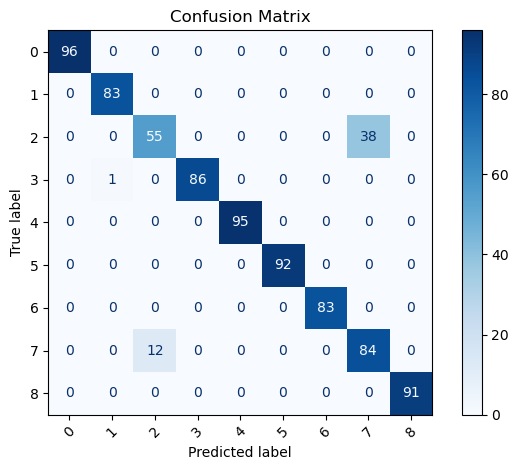

In [11]:
# 📊 Confusion Matrix
cm = confusion_matrix(y_test_tensor, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("nn_confusion_matrix.png", dpi=300)
plt.show()

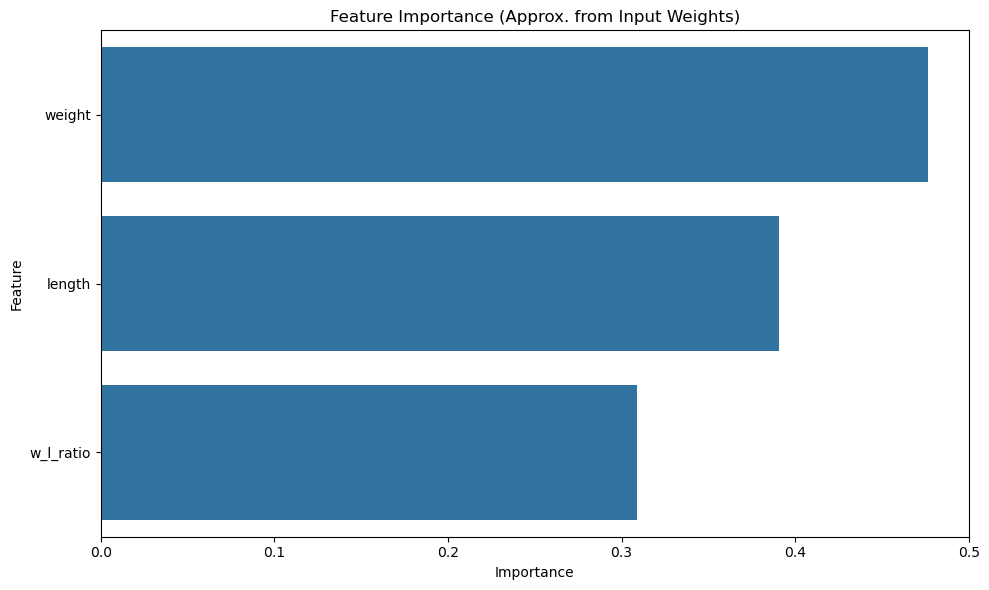

In [15]:
# 🎯 Feature Importance Approximation
first_layer_weights = model.fc1.weight.data.abs().mean(dim=0).numpy()
feature_names = X_train.columns.tolist()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': first_layer_weights
}).sort_values(by='Importance', ascending=False)

# 📊 Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance (Approx. from Input Weights)")
plt.tight_layout()
plt.savefig("nn_feature_importance.png", dpi=300)
plt.show()
